## Importamos librerías

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import os


In [2]:
RANDOM_STATE = 42
BATCH_SIZE = 128

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Determinar el dispositivo (GPU si está disponible, si no CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(RANDOM_STATE) # Inicializa la semilla para la GPU
else:
    device = torch.device("cpu")
    
print(f"\nUsando dispositivo: {device}")



num_workers = os.cpu_count() // 2 # Número de workers. La mitad de los núcleos disponibles (heuristico común)


Usando dispositivo: cpu


## Cargamos el dataset y hacemos las divisiones

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from preprocessing import get_preprocessing_pipeline
from sklearn.preprocessing import LabelEncoder

file_path = "./data/thyroidDF.csv"
df = pd.read_csv(file_path)


# Simplify the target variable

class_mapping = {
    '-': 'negative',
    'K': 'hyperthyroid', 'B': 'hyperthyroid', 'H|K': 'hyperthyroid',
    'KJ': 'hyperthyroid', 'GI': 'hyperthyroid',
    'G': 'hypothyroid', 'I': 'hypothyroid', 'F': 'hypothyroid', 'C|I': 'hypothyroid',
    'E': 'negative', 'LJ': 'negative', 'D|R': 'negative',
}

df['target'] = df['target'].map(class_mapping)

df = df.dropna(subset=['target'])

measured_cols = [col for col in df.columns if col.endswith('_measured')]

columns_to_drop = [
    'patient_id',
    *measured_cols,  # Unpack the list of measured columns
    'TBG', # excessive missing values (96,6%)
]

X = df.drop(columns_to_drop + ['target'], axis=1)
y = df['target']

test_size=0.2


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=RANDOM_STATE)


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

y_train_full = le.fit_transform(y_train_full)

le.classes_


array(['hyperthyroid', 'hypothyroid', 'negative'], dtype=object)

## Preprocesamiento

Creo un pipeline de preprocesamiento

In [4]:
from preprocessing import scale_target

# Obtener el preprocesador definido en el archivo preprocessing.py
preprocessing_pipeline = get_preprocessing_pipeline()

# Ajustar el pipeline CON SOLO los datos de entrenamiento
preprocessing_pipeline.fit(X_train)

# Aplicar el pipeline para transformar los datos de entrada
X_train_prep = preprocessing_pipeline.transform(X_train)
X_val_prep = preprocessing_pipeline.transform(X_val)
X_test_prep = preprocessing_pipeline.transform(X_test)


X_train_full_prep = preprocessing_pipeline.transform(X_train_full)


## Convertir a tensores y crear los dataloaders

In [5]:
# Convertir los datos preprocesados a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_prep.astype(np.float32)).to(device)
X_valid_tensor = torch.tensor(X_val_prep.astype(np.float32)).to(device)
X_test_tensor = torch.tensor(X_test_prep.astype(np.float32)).to(device)

X_train_full_tensor = torch.tensor(X_train_full_prep.astype(np.float32)).to(device)

y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_valid_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

y_train_full_tensor = torch.tensor(y_train_full, dtype=torch.long).to(device)


# Crear los dataloaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

train_full_loader = DataLoader(TensorDataset(X_train_full_tensor, y_train_full_tensor), batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)



## Modelo de la red neuronal sencillo

In [6]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size) # Capa de entrada
        self.activation = torch.nn.ReLU() # Función de activación
        self.linear2 = torch.nn.Linear(hidden_size, output_size) # Capa de salida
        self.softmax = torch.nn.Softmax() # Función de salida
    
    def forward(self, x): # Definimos el flujo de datos
        x = self.linear1(x) # Capa de entrada
        x = self.activation(x) # Función de activación
        x = self.linear2(x) # Capa de salida
        x = self.softmax(x) # Función de salida
        return x    

## Seteamos los tamaños de la entrada, capas y salidas. A mayores indicamosla función de pérdida y el optimizador

In [7]:
import torch.optim as optim
torch.manual_seed(42) # Fijamos la semilla para asegurar reproducibilidad

input_size = X_train_tensor.shape[1] # Capa de entrada: número de características
hidden_size = 64 # Tamaño de la capa oculta
output_size = 3 # Capa de salida: número de clases

model = SimpleNN(input_size, hidden_size, output_size) # Instanciamos el modelo

criterion = nn.CrossEntropyLoss() # Función de pérdida

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)#optim.Adam(model.parameters(), lr=0.01) # Optimizador



## Entrenamos el modelo con validación

In [8]:
import time

epochs = 10 # Número de épocas para el entrenamiento
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = time.time()  # justo antes del bucle de entrenamiento


for epoch in range(epochs):
    epoch_start = time.time()  # inicio de la época
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0

    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(inputs)
        #print(labels)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validación
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data in valid_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss / len(valid_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Época {epoch+1}: '
          f'Train Loss={train_loss:.3f}, Acc={train_acc:.2f}% | '
          f'Val Loss={val_loss:.3f}, Acc={val_acc:.2f}% | '
          f'Tiempo: {time.time() - epoch_start:.2f} s')
    
total_time = time.time() - start_time
print(f'\n Tiempo total de entrenamiento: {total_time:.2f} segundos')

c:\Users\a24mariorb\AppData\Local\anaconda3\envs\tensorflow\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Época 1: Train Loss=0.974, Acc=82.03% | Val Loss=0.852, Acc=84.93% | Tiempo: 7.77 s
Época 2: Train Loss=0.794, Acc=82.34% | Val Loss=0.723, Acc=85.69% | Tiempo: 7.62 s
Época 3: Train Loss=0.728, Acc=84.47% | Val Loss=0.693, Acc=87.06% | Tiempo: 7.63 s
Época 4: Train Loss=0.707, Acc=85.80% | Val Loss=0.680, Acc=87.90% | Tiempo: 7.70 s
Época 5: Train Loss=0.688, Acc=86.52% | Val Loss=0.670, Acc=88.58% | Tiempo: 7.75 s
Época 6: Train Loss=0.683, Acc=87.29% | Val Loss=0.662, Acc=89.42% | Tiempo: 7.70 s
Época 7: Train Loss=0.678, Acc=88.22% | Val Loss=0.656, Acc=90.11% | Tiempo: 7.61 s
Época 8: Train Loss=0.667, Acc=88.85% | Val Loss=0.652, Acc=90.64% | Tiempo: 8.04 s
Época 9: Train Loss=0.663, Acc=89.07% | Val Loss=0.650, Acc=90.87% | Tiempo: 7.75 s
Época 10: Train Loss=0.661, Acc=89.42% | Val Loss=0.648, Acc=90.94% | Tiempo: 7.66 s

 Tiempo total de entrenamiento: 77.24 segundos


Se ha conseguido un Accuracy=90.94% en validación

## Graficar curvas de Aprendizaje

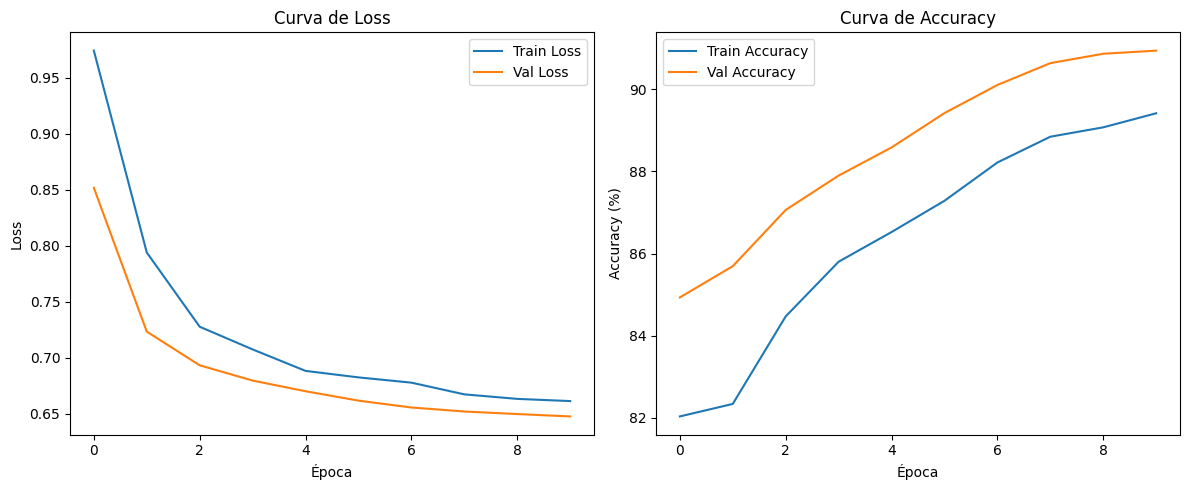

In [9]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy (%)')
plt.title('Curva de Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Entrenar la red neuronal con el full train dataset

Una vez entrenado y probado con validación quiero entrenar el full train y luego validar contra test para sacar las métricas de los mismos conjuntos que en el baseline.

In [10]:
epochs = 10  # Número de épocas para el entrenamiento con el conjunto completo
model.train()  # Modo de entrenamiento

for epoch in range(epochs):
    running_loss = 0.0
    total = 0
    correct = 0

    for i, data in enumerate(train_full_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Estadísticas de precisión en entrenamiento (opcional)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_full_loader)
    epoch_acc = 100 * correct / total
    print(f'Época {epoch+1}: Loss={epoch_loss:.3f}, Accuracy={epoch_acc:.2f}%')

print('Entrenamiento completado con el conjunto completo.')



c:\Users\a24mariorb\AppData\Local\anaconda3\envs\tensorflow\lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Época 1: Loss=0.658, Accuracy=89.84%
Época 2: Loss=0.657, Accuracy=89.95%
Época 3: Loss=0.655, Accuracy=90.04%
Época 4: Loss=0.653, Accuracy=90.18%
Época 5: Loss=0.652, Accuracy=90.26%
Época 6: Loss=0.650, Accuracy=90.50%
Época 7: Loss=0.649, Accuracy=90.55%
Época 8: Loss=0.649, Accuracy=90.68%
Época 9: Loss=0.649, Accuracy=90.77%
Época 10: Loss=0.647, Accuracy=90.88%
Entrenamiento completado con el conjunto completo.


## Evaluar contra test

In [11]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data

        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy contra test: {100 * correct // total} %')

Accuracy contra test: 89 %
